# ML004.03: Getting all the data

In this script we:
- Use the csv files we generated
- Extract the actual wav file
- Apply the special function to generate spectral images
- Reshape the data to the expected tensor size
- Store all this data into a single pickled object for use in the next script

# Imports

In [11]:
import librosa
import pylab
import numpy as np
from tensorflow.keras.utils import to_categorical
import random
import os
import pickle

# Parameters:

The parameters in the cell below are tagged with the label "parameters" and can be adjusted externally e.g. with a Papermill script to perform hyperparameter optimization. \
Also the filepaths where the: 
1. POS_00001.wav etc... files are stored for the training data
2. Where the CNN will be saved

In [12]:
#DATASET_DIRECTORY = "C:\\CloudData\\2024\\Nepal\\N001\\Dataset"
DATASET_DIRECTORY = "C:\\Users\\Amogh\\OneDrive - University of Cambridge\\Programming-New\\CaracalChitalDetector\\cnn\\output"  # 1.
output_prefix = "03MLouput20240811v001.keras"  # 2.

ML_SR = 8000 # Target sampling rate
SPECD_FFT_LEN =  512 # Real FFT length (in the M4F - we use double of this on the PC as we don't do single-sided)
ML_BIN_AGG = 14 # Number of frequency bins (vertical dimension)
ML_FLO = 600 # Low freq
ML_FHI = 1400 # High freq
ML_FFT_STRIDE=1024 # Stride length in audio samples
ML_NUM_FFT_STRIDES = 12 # How many strides make up a sample
FILEPREFIX = "templateMaker003_002" # what to save the output files as
THRESHOLDED = False # Threshold the template or not

## Window to spectral features

This is our simple magic function that ingests a single FFT window of data and turns it into spectral patches. We use these spectral patches as "features". Each time it is called it makes a "column" of the spectral image, with height NUMBINS.

We use a single-sided FFT as it takes up less space on the microcontroller by exploiting FFT symmetry. We simply aggregate the FFT bins together.

NB: There are numerous optimizations that could be done here:
* Use a smaller FFT (e.g. 128), run it 4x and aggregate along the temporal dimension
* Rather than computing the whole FFT and discarding most of it, compute the explicit DFT products for each filter band e.g. using something like the Goertzel algorithm
* Use a FIR/IIR filter as a bandpass filter to extract the spectral magnitude

In [4]:
def chunkToBinsFixed(chunk,fLo,fHi,numbins,sr):
    """convert a chunk (window) to spectral image.
    Provide the low and high frequencies in Hz for a spectral windowing
    numbins are the number of output bins between flo and fhi
    Provide the sample rate in Hz"""
    CMPLX_FFT_LEN = len(chunk)*2
    fS = np.fft.fft(chunk,n=CMPLX_FFT_LEN) # fft - note we double it for the cmplx fft
    fRes = sr/(CMPLX_FFT_LEN)   # frequency per cmplx bin
    # Find the bin indices - map from frequency to FFT index
    binLo = int(fLo/sr*CMPLX_FFT_LEN)
    binHi = int(fHi/sr*CMPLX_FFT_LEN)
    specSize = int((binHi-binLo)/numbins)
    binTotals = np.zeros(numbins)
    for k in range(numbins):
        dbSum = 0
        for j in range(specSize):
            idx = binLo + (k * specSize) + j # NB not numbins!
            # Convert complex magnitude to absolute value
            absVal = np.abs(fS[idx])
            # We add an offset so we don't take log of tiny numbers. We can explore what a sensible offset is - 1.0 is probably too high.
            absVal += 1.0 
            # Convert to "power" by taking log
            dbVal = np.log(absVal) # NB natural (not log10) base!
            # Add up all the "powers" - again, this is probably not "correct", but we are just trying to work out some useful input features
            dbSum += dbVal
        binTotals[k] = dbSum
    return binTotals

# Step 1: Example

We load and plot a random sample.

## Wavefile to spectral image

This ingests a wavefile and outputs a spectral image of the correct dimensions (ML_BIN_AGG x ML_NUM_FFT_STRIDES). Because we use a sliding window on the Caracal, we start computing this spectral image at a random offset position. 

We optionally:
- Threshold the input spectral bins to ensure they are strictly positive (which they normally are)
- Scale (normalize) each spectral image to lie between [0,1]. This per-frame normalization helps to deal with the wide dynamic range encountered in the field.

Improvements:
- Rather than just using each sample once with a random offset, we could repeatedly call this function for each sample N times, building an augmented dataset

2 different implemetations depending on if we want to use random numbers or not (when same clip is inputed should we get the same output everytime the function is ran)

In [5]:
# With random

def wavFileToSpecImg(fullfilename,num_strides,target_sr=8000,random_offset=4000,THRESHOLDED=True,SCALED=True):
    aud,sr = librosa.load(fullfilename,sr=target_sr)
    tList = []
    startIdx = int(np.random.uniform(random_offset))
    for idx in range(0,num_strides*ML_FFT_STRIDE,int(ML_FFT_STRIDE)):
        clip = aud[idx+startIdx:idx+startIdx+SPECD_FFT_LEN]
        q = chunkToBinsFixed(clip,ML_FLO,ML_FHI,ML_BIN_AGG,ML_SR)
        tList.append(q)
    tList = np.array(tList)
    # Thresholding
    if THRESHOLDED:
        tList = (tList >0)*tList
    if SCALED:
        # Scale the dB mag spec to +1/-1
        maxVal = np.max(tList)
        minVal = np.min(tList)
        tList = (tList-minVal)/(maxVal-minVal)
    return np.array(tList)


# Without random
'''
def wavFileToSpecImg(fullfilename,num_strides,target_sr=8000,THRESHOLDED=True,SCALED=True):
    aud,sr = librosa.load(fullfilename,sr=target_sr)
    tList = []
    for idx in range(0,num_strides*ML_FFT_STRIDE,int(ML_FFT_STRIDE)):
        clip = aud[idx:idx+SPECD_FFT_LEN]
        q = chunkToBinsFixed(clip,ML_FLO,ML_FHI,ML_BIN_AGG,ML_SR)
        tList.append(q)
    tList = np.array(tList)
    # Thresholding
    if THRESHOLDED:
        tList = (tList >0)*tList
    if SCALED:
        # Scale the dB mag spec to +1/-1
        maxVal = np.max(tList)
        minVal = np.min(tList)
        tList = (tList-minVal)/(maxVal-minVal)
    return np.array(tList)
'''

'\ndef wavFileToSpecImg(fullfilename,num_strides,target_sr=8000,THRESHOLDED=True,SCALED=True):\n    aud,sr = librosa.load(fullfilename,sr=target_sr)\n    tList = []\n    for idx in range(0,num_strides*ML_FFT_STRIDE,int(ML_FFT_STRIDE)):\n        clip = aud[idx:idx+SPECD_FFT_LEN]\n        q = chunkToBinsFixed(clip,ML_FLO,ML_FHI,ML_BIN_AGG,ML_SR)\n        tList.append(q)\n    tList = np.array(tList)\n    # Thresholding\n    if THRESHOLDED:\n        tList = (tList >0)*tList\n    if SCALED:\n        # Scale the dB mag spec to +1/-1\n        maxVal = np.max(tList)\n        minVal = np.min(tList)\n        tList = (tList-minVal)/(maxVal-minVal)\n    return np.array(tList)\n'

We can plot a 3x3 grid of randomly drawn samples from each category to show what these spectral images look like

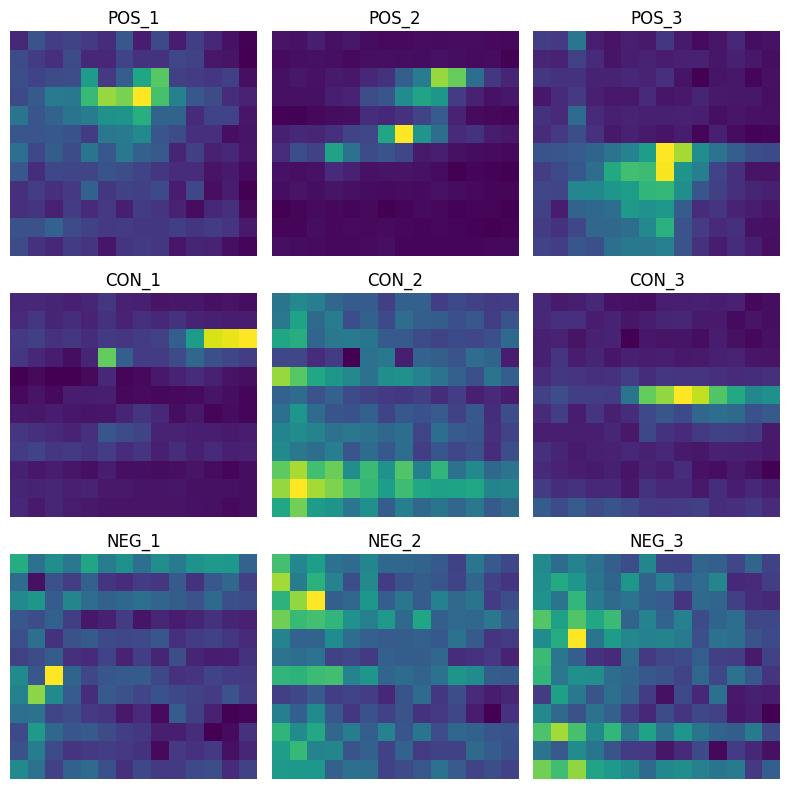

In [6]:
# Max sampling index
MAX_INDEX = 100

def select_random_files(prefix, max_index, num_files=3):
    indices = random.sample(range(max_index + 1), num_files)
    filenames = [f"{prefix}_{index:06d}.wav" for index in indices]
    return filenames


def create_tiled_subplots(max_index):
    prefixes = ["POS", "CON", "NEG"]
    fig, axes = pylab.subplots(3, 3, figsize=(8, 8))

    for i, prefix in enumerate(prefixes):
        filenames = select_random_files(prefix, max_index)
        full_filenames = [os.path.join(DATASET_DIRECTORY,f) for f in filenames]
        for j, filename in enumerate(full_filenames):
            image = wavFileToSpecImg(filename,num_strides=ML_NUM_FFT_STRIDES)
            ax = axes[i, j]
            ax.imshow(image, aspect='auto', cmap='viridis')
            ax.set_title(f"{prefix}_{j + 1}")
            ax.axis('off')
    
    pylab.tight_layout()
    pylab.show()

# Main code
create_tiled_subplots(MAX_INDEX)

## Helper function
This is a helper function to turn a given spectral image into a flattened C array. \
This is useful for checking that the CNN on the Caracal actually works

In [7]:
def specImg2C(specImg):
    flatty = specImg.flatten(order='C')
    print(f"const float32_t sample_buffer [{np.shape(flatty)[0]}]={{") 
    for k in range(len(flatty)):
        if k < (len(flatty))-1:
            print(f"{flatty[k]},")
        else:
            print(f"{flatty[k]}}};")

# Main machine learning loop

### Step 1: Load and convert wavefiles to spectral images

In [17]:
# Step 1: Load images and labels
def load_images_and_labels(data_dir):
    images = []
    labels = []
    
    for filename in os.listdir(data_dir):
        if filename.startswith("POS"):
            label = 1
        elif filename.startswith("NEG") or filename.startswith("CON"):
        #elif filename.startswith("CON"):
            label = 0
        else:
            continue
        
        file_path = os.path.join(data_dir, filename)
        clipImg = wavFileToSpecImg(file_path,num_strides=ML_NUM_FFT_STRIDES)
        images.append(clipImg)
        labels.append(label)
    
    return np.array(images), np.array(labels)

images,labels= load_images_and_labels(DATASET_DIRECTORY)

CON_000000.wav
CON_000001.wav
CON_000002.wav
CON_000003.wav
CON_000004.wav
CON_000005.wav
CON_000006.wav
CON_000007.wav
CON_000008.wav
CON_000009.wav
CON_000010.wav
CON_000011.wav
CON_000012.wav
CON_000013.wav
CON_000014.wav
CON_000015.wav
CON_000016.wav
CON_000017.wav
CON_000018.wav
CON_000019.wav
CON_000020.wav
CON_000021.wav
CON_000022.wav
CON_000023.wav
CON_000024.wav
CON_000025.wav
CON_000026.wav
CON_000027.wav
CON_000028.wav
CON_000029.wav
CON_000030.wav
CON_000031.wav
CON_000032.wav
CON_000033.wav
CON_000034.wav
CON_000035.wav
CON_000036.wav
CON_000037.wav
CON_000038.wav
CON_000039.wav
CON_000040.wav
CON_000041.wav
CON_000042.wav
CON_000043.wav
CON_000044.wav
CON_000045.wav
CON_000046.wav
CON_000047.wav
CON_000048.wav
CON_000049.wav
CON_000050.wav
CON_000051.wav
CON_000052.wav
CON_000053.wav
CON_000054.wav
CON_000055.wav
CON_000056.wav
CON_000057.wav
CON_000058.wav
CON_000059.wav
CON_000060.wav
CON_000061.wav
CON_000062.wav
CON_000063.wav
CON_000064.wav
CON_000065.wav
CON_000066

### Step 2: Reshape to the expected tensor size
Reshape to (num_samples, height, width, channels)

In [14]:
def preprocess_images(images):
    # Reshape to (num_samples, height, width, channels)
    return images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)

images = preprocess_images(images)

labels = to_categorical(labels)

In [16]:
print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


### Step 3
Store all X and Y data externally for easy access in different files

In [10]:
with open('all_data.pkl', 'wb') as f:
    pickle.dump((images, labels), f)